# Setup

In [1]:
import pyspark

spark = (
    pyspark.sql.SparkSession.builder.appName("MachineLearning")
    .master("yarn")
    .config("spark.executor.memory", "512m")
    .config("spark.executor.instances", "2")
    .getOrCreate()
)
spark


Setting default log level to "WARN".
To adjust logging level use sc.setLogLevel(newLevel). For SparkR, use setLogLevel(newLevel).


23/02/20 04:53:22 WARN NativeCodeLoader: Unable to load native-hadoop library for your platform... using builtin-java classes where applicable
23/02/20 04:53:23 WARN Client: Neither spark.yarn.jars nor spark.yarn.archive is set, falling back to uploading libraries under SPARK_HOME.


In [2]:
from pyspark.sql import SparkSession
from pyspark import sql
import seaborn as sns
import matplotlib.pyplot as plt
import pandas as pd

# JSON Object Classes

In [3]:
class Category:
  def __init__(self, cat_pattern):
    self.depth1, self.depth2, self.depth3, self.depth4 = list(map(int, cat_pattern.split("/")))[:4]
  
  def __str__(self):
    return "{}/{}/{}/{}".format(self.depth1, self.depth2, self.depth3, self.depth4)

In [4]:
class ProductStock:
  def __init__(self, id, price, quantity_sold, rating_average):
    self.id = id
    self.price = float(price)
    self.rating_avg = float(rating_average)
    self.qty_sold = int(quantity_sold)
  
  def __str__(self):
    return "{}, {}, {}, {}".format(self.id, self.price, self.qty_sold, self.rating_avg)

  @staticmethod
  def create_columns():
    return ['ID', 'Price', 'Sold', 'Rating']

  @staticmethod
  def parse_from_json(json_object: dict):
    try:
      id = json_object['id']
    except Exception:
      id = None

    try:
      price = json_object['price']
    except Exception:
      price = None

    try:
      quantity_sold = json_object['quantity_sold']['value']
    except Exception:
      quantity_sold = -1

    try:
      rating_average = json_object['rating_average']
    except Exception:
      rating_average = None
    


    return ProductStock(id, price, quantity_sold, rating_average)
    
  def create_tuple(self):
    return (self.id, self.price, self.qty_sold, self.rating_avg)

# Load JSON data

In [5]:
import time
import json
import happybase

local_time = time.time()
connection = happybase.Connection("node-master", 9090)
products_table = connection.table("products_table")

i = 0
products = []
for key, data in products_table.scan():
    i += 1
    if i % 10000 == 0:
        print(f"time = {round(time.time() - local_time)}, i={i}, key={key}")
    product_json = json.loads(data[b'product_info:json_string'].decode("utf-8-sig"))
    products.append(ProductStock.parse_from_json(product_json))

time = 7, i=10000, key=b'109868445'
time = 13, i=20000, key=b'117536107'
time = 19, i=30000, key=b'126958862'
time = 25, i=40000, key=b'136521539'
time = 32, i=50000, key=b'143912721'
time = 38, i=60000, key=b'152101602'
time = 44, i=70000, key=b'162111762'
time = 50, i=80000, key=b'169580000'
time = 57, i=90000, key=b'174243477'
time = 63, i=100000, key=b'180745239'
time = 69, i=110000, key=b'189643369'
time = 76, i=120000, key=b'196057459'
time = 82, i=130000, key=b'201226118'
time = 88, i=140000, key=b'207395334'
time = 94, i=150000, key=b'213064221'
time = 100, i=160000, key=b'27583324'
time = 106, i=170000, key=b'46377009'
time = 112, i=180000, key=b'57466184'
time = 119, i=190000, key=b'74774962'
time = 125, i=200000, key=b'89963479'


In [6]:
connection.close()

In [7]:
df = spark.createDataFrame(list(map(lambda ds: ds.create_tuple(), products)), ProductStock.create_columns())

In [8]:
df.show()

23/02/20 04:58:39 WARN TaskSetManager: Stage 0 contains a task of very large size (3088 KiB). The maximum recommended task size is 1000 KiB.


+---------+---------+----+------+
|       ID|    Price|Sold|Rating|
+---------+---------+----+------+
| 10000121|  89000.0|   4|   0.0|
|100002175|  79000.0|  28|   4.3|
| 10000230| 295000.0|   1|   0.0|
|100002509|  75000.0|  -1|   0.0|
| 10000298|  85000.0|  -1|   0.0|
|100003807| 127200.0|  -1|   0.0|
|  1000065| 113520.0|  -1|   0.0|
|100010047| 104050.0|  -1|   0.0|
|100010406| 109000.0|  -1|   0.0|
| 10001112|  35000.0|  43|   4.5|
|  1000115|  78000.0|   5|   0.0|
|100012960| 125000.0|  -1|   0.0|
| 10001308| 119000.0|   1|   0.0|
|100013289| 155000.0|  -1|   0.0|
| 10001353|1237500.0| 250|   4.8|
| 10001382| 300000.0|2429|   4.7|
|100013887| 265000.0|  -1|   0.0|
|100014021| 125000.0|  -1|   0.0|
|100014261| 185000.0|  -1|   0.0|
|100014637| 255000.0|  -1|   0.0|
+---------+---------+----+------+
only showing top 20 rows



# Training Kmeans

In [9]:
from pyspark.ml.feature import VectorAssembler
assemble=VectorAssembler(inputCols=['Price', 'Sold', 'Rating'], outputCol='features')
assembled_data=assemble.transform(df)

In [10]:
from pyspark.ml.feature import StandardScaler
scale=StandardScaler(inputCol='features',outputCol='standardized')
data_scale=scale.fit(assembled_data)
data_scale_output=data_scale.transform(assembled_data)
data_scale_output.show()

23/02/20 04:58:42 WARN TaskSetManager: Stage 1 contains a task of very large size (3088 KiB). The maximum recommended task size is 1000 KiB.


23/02/20 04:58:47 WARN TaskSetManager: Stage 4 contains a task of very large size (3088 KiB). The maximum recommended task size is 1000 KiB.


+---------+---------+----+------+--------------------+--------------------+
|       ID|    Price|Sold|Rating|            features|        standardized|
+---------+---------+----+------+--------------------+--------------------+
| 10000121|  89000.0|   4|   0.0|   [89000.0,4.0,0.0]|[0.01738974917893...|
|100002175|  79000.0|  28|   4.3|  [79000.0,28.0,4.3]|[0.01543584477680...|
| 10000230| 295000.0|   1|   0.0|  [295000.0,1.0,0.0]|[0.05764017986275...|
|100002509|  75000.0|  -1|   0.0|  [75000.0,-1.0,0.0]|[0.01465428301595...|
| 10000298|  85000.0|  -1|   0.0|  [85000.0,-1.0,0.0]|[0.01660818741808...|
|100003807| 127200.0|  -1|   0.0| [127200.0,-1.0,0.0]|[0.02485366399506...|
|  1000065| 113520.0|  -1|   0.0| [113520.0,-1.0,0.0]|[0.02218072277294...|
|100010047| 104050.0|  -1|   0.0| [104050.0,-1.0,0.0]|[0.02033037530413...|
|100010406| 109000.0|  -1|   0.0| [109000.0,-1.0,0.0]|[0.02129755798318...|
| 10001112|  35000.0|  43|   4.5|  [35000.0,43.0,4.5]|[0.00683866540744...|
|  1000115| 

In [11]:
from pyspark.ml.clustering import KMeans
from pyspark.ml.evaluation import ClusteringEvaluator
import numpy as np
silhouette_score=[]
evaluator = ClusteringEvaluator(predictionCol='prediction', featuresCol='standardized', \
                                metricName='silhouette', distanceMeasure='squaredEuclidean')

cost = np.zeros(10)

for i in range(2,10):
        
    KMeans_algo=KMeans(featuresCol='standardized', k=i)

    KMeans_fit=KMeans_algo.fit(data_scale_output)

    cost[i] = KMeans_fit.summary.trainingCost

    output=KMeans_fit.transform(data_scale_output)

    score=evaluator.evaluate(output)

    silhouette_score.append(score)

    print("Silhouette Score:",score)

23/02/20 04:58:48 WARN TaskSetManager: Stage 5 contains a task of very large size (3088 KiB). The maximum recommended task size is 1000 KiB.


23/02/20 04:58:51 WARN TaskSetManager: Stage 6 contains a task of very large size (3088 KiB). The maximum recommended task size is 1000 KiB.


23/02/20 04:58:53 WARN TaskSetManager: Stage 7 contains a task of very large size (3088 KiB). The maximum recommended task size is 1000 KiB.


23/02/20 04:58:54 WARN TaskSetManager: Stage 8 contains a task of very large size (3088 KiB). The maximum recommended task size is 1000 KiB.


23/02/20 04:58:56 WARN TaskSetManager: Stage 9 contains a task of very large size (3088 KiB). The maximum recommended task size is 1000 KiB.


23/02/20 04:58:58 WARN TaskSetManager: Stage 10 contains a task of very large size (3088 KiB). The maximum recommended task size is 1000 KiB.


23/02/20 04:59:00 WARN TaskSetManager: Stage 11 contains a task of very large size (3088 KiB). The maximum recommended task size is 1000 KiB.


23/02/20 04:59:01 WARN TaskSetManager: Stage 13 contains a task of very large size (3088 KiB). The maximum recommended task size is 1000 KiB.


23/02/20 04:59:03 WARN TaskSetManager: Stage 15 contains a task of very large size (3088 KiB). The maximum recommended task size is 1000 KiB.


23/02/20 04:59:05 WARN TaskSetManager: Stage 17 contains a task of very large size (3088 KiB). The maximum recommended task size is 1000 KiB.


23/02/20 04:59:07 WARN TaskSetManager: Stage 20 contains a task of very large size (3088 KiB). The maximum recommended task size is 1000 KiB.


23/02/20 04:59:10 WARN TaskSetManager: Stage 22 contains a task of very large size (3088 KiB). The maximum recommended task size is 1000 KiB.


Silhouette Score: 0.9999604095773107
23/02/20 04:59:12 WARN TaskSetManager: Stage 25 contains a task of very large size (3088 KiB). The maximum recommended task size is 1000 KiB.


23/02/20 04:59:15 WARN TaskSetManager: Stage 26 contains a task of very large size (3088 KiB). The maximum recommended task size is 1000 KiB.


23/02/20 04:59:16 WARN TaskSetManager: Stage 27 contains a task of very large size (3088 KiB). The maximum recommended task size is 1000 KiB.


23/02/20 04:59:18 WARN TaskSetManager: Stage 28 contains a task of very large size (3088 KiB). The maximum recommended task size is 1000 KiB.


23/02/20 04:59:19 WARN TaskSetManager: Stage 29 contains a task of very large size (3088 KiB). The maximum recommended task size is 1000 KiB.


23/02/20 04:59:21 WARN TaskSetManager: Stage 30 contains a task of very large size (3088 KiB). The maximum recommended task size is 1000 KiB.


23/02/20 04:59:23 WARN TaskSetManager: Stage 31 contains a task of very large size (3088 KiB). The maximum recommended task size is 1000 KiB.


23/02/20 04:59:24 WARN TaskSetManager: Stage 33 contains a task of very large size (3088 KiB). The maximum recommended task size is 1000 KiB.


23/02/20 04:59:26 WARN TaskSetManager: Stage 35 contains a task of very large size (3088 KiB). The maximum recommended task size is 1000 KiB.


23/02/20 04:59:28 WARN TaskSetManager: Stage 37 contains a task of very large size (3088 KiB). The maximum recommended task size is 1000 KiB.


23/02/20 04:59:30 WARN TaskSetManager: Stage 40 contains a task of very large size (3088 KiB). The maximum recommended task size is 1000 KiB.


23/02/20 04:59:32 WARN TaskSetManager: Stage 42 contains a task of very large size (3088 KiB). The maximum recommended task size is 1000 KiB.


Silhouette Score: 0.999920210359584
23/02/20 04:59:34 WARN TaskSetManager: Stage 45 contains a task of very large size (3088 KiB). The maximum recommended task size is 1000 KiB.


23/02/20 04:59:37 WARN TaskSetManager: Stage 46 contains a task of very large size (3088 KiB). The maximum recommended task size is 1000 KiB.


23/02/20 04:59:38 WARN TaskSetManager: Stage 47 contains a task of very large size (3088 KiB). The maximum recommended task size is 1000 KiB.


23/02/20 04:59:40 WARN TaskSetManager: Stage 48 contains a task of very large size (3088 KiB). The maximum recommended task size is 1000 KiB.


23/02/20 04:59:41 WARN TaskSetManager: Stage 49 contains a task of very large size (3088 KiB). The maximum recommended task size is 1000 KiB.


23/02/20 04:59:43 WARN TaskSetManager: Stage 50 contains a task of very large size (3088 KiB). The maximum recommended task size is 1000 KiB.


23/02/20 04:59:45 WARN TaskSetManager: Stage 51 contains a task of very large size (3088 KiB). The maximum recommended task size is 1000 KiB.


23/02/20 04:59:46 WARN TaskSetManager: Stage 53 contains a task of very large size (3088 KiB). The maximum recommended task size is 1000 KiB.


23/02/20 04:59:48 WARN TaskSetManager: Stage 55 contains a task of very large size (3088 KiB). The maximum recommended task size is 1000 KiB.


23/02/20 04:59:50 WARN TaskSetManager: Stage 57 contains a task of very large size (3088 KiB). The maximum recommended task size is 1000 KiB.


23/02/20 04:59:51 WARN TaskSetManager: Stage 59 contains a task of very large size (3088 KiB). The maximum recommended task size is 1000 KiB.


23/02/20 04:59:53 WARN TaskSetManager: Stage 61 contains a task of very large size (3088 KiB). The maximum recommended task size is 1000 KiB.


23/02/20 04:59:55 WARN TaskSetManager: Stage 63 contains a task of very large size (3088 KiB). The maximum recommended task size is 1000 KiB.


23/02/20 04:59:56 WARN TaskSetManager: Stage 65 contains a task of very large size (3088 KiB). The maximum recommended task size is 1000 KiB.


23/02/20 04:59:58 WARN TaskSetManager: Stage 67 contains a task of very large size (3088 KiB). The maximum recommended task size is 1000 KiB.


23/02/20 05:00:00 WARN TaskSetManager: Stage 69 contains a task of very large size (3088 KiB). The maximum recommended task size is 1000 KiB.


23/02/20 05:00:01 WARN TaskSetManager: Stage 71 contains a task of very large size (3088 KiB). The maximum recommended task size is 1000 KiB.


23/02/20 05:00:03 WARN TaskSetManager: Stage 73 contains a task of very large size (3088 KiB). The maximum recommended task size is 1000 KiB.


23/02/20 05:00:05 WARN TaskSetManager: Stage 75 contains a task of very large size (3088 KiB). The maximum recommended task size is 1000 KiB.


23/02/20 05:00:07 WARN TaskSetManager: Stage 78 contains a task of very large size (3088 KiB). The maximum recommended task size is 1000 KiB.


23/02/20 05:00:09 WARN TaskSetManager: Stage 80 contains a task of very large size (3088 KiB). The maximum recommended task size is 1000 KiB.


Silhouette Score: 0.7842380804073168
23/02/20 05:00:11 WARN TaskSetManager: Stage 83 contains a task of very large size (3088 KiB). The maximum recommended task size is 1000 KiB.


23/02/20 05:00:14 WARN TaskSetManager: Stage 84 contains a task of very large size (3088 KiB). The maximum recommended task size is 1000 KiB.


23/02/20 05:00:15 WARN TaskSetManager: Stage 85 contains a task of very large size (3088 KiB). The maximum recommended task size is 1000 KiB.


23/02/20 05:00:17 WARN TaskSetManager: Stage 86 contains a task of very large size (3088 KiB). The maximum recommended task size is 1000 KiB.


23/02/20 05:00:18 WARN TaskSetManager: Stage 87 contains a task of very large size (3088 KiB). The maximum recommended task size is 1000 KiB.


23/02/20 05:00:20 WARN TaskSetManager: Stage 88 contains a task of very large size (3088 KiB). The maximum recommended task size is 1000 KiB.


23/02/20 05:00:22 WARN TaskSetManager: Stage 89 contains a task of very large size (3088 KiB). The maximum recommended task size is 1000 KiB.


23/02/20 05:00:23 WARN TaskSetManager: Stage 91 contains a task of very large size (3088 KiB). The maximum recommended task size is 1000 KiB.


23/02/20 05:00:25 WARN TaskSetManager: Stage 93 contains a task of very large size (3088 KiB). The maximum recommended task size is 1000 KiB.


23/02/20 05:00:27 WARN TaskSetManager: Stage 95 contains a task of very large size (3088 KiB). The maximum recommended task size is 1000 KiB.


23/02/20 05:00:28 WARN TaskSetManager: Stage 97 contains a task of very large size (3088 KiB). The maximum recommended task size is 1000 KiB.


23/02/20 05:00:30 WARN TaskSetManager: Stage 99 contains a task of very large size (3088 KiB). The maximum recommended task size is 1000 KiB.


23/02/20 05:00:32 WARN TaskSetManager: Stage 101 contains a task of very large size (3088 KiB). The maximum recommended task size is 1000 KiB.


23/02/20 05:00:33 WARN TaskSetManager: Stage 103 contains a task of very large size (3088 KiB). The maximum recommended task size is 1000 KiB.


23/02/20 05:00:35 WARN TaskSetManager: Stage 105 contains a task of very large size (3088 KiB). The maximum recommended task size is 1000 KiB.


23/02/20 05:00:37 WARN TaskSetManager: Stage 107 contains a task of very large size (3088 KiB). The maximum recommended task size is 1000 KiB.


23/02/20 05:00:39 WARN TaskSetManager: Stage 109 contains a task of very large size (3088 KiB). The maximum recommended task size is 1000 KiB.


23/02/20 05:00:41 WARN TaskSetManager: Stage 111 contains a task of very large size (3088 KiB). The maximum recommended task size is 1000 KiB.


23/02/20 05:00:43 WARN TaskSetManager: Stage 113 contains a task of very large size (3088 KiB). The maximum recommended task size is 1000 KiB.


23/02/20 05:00:44 WARN TaskSetManager: Stage 115 contains a task of very large size (3088 KiB). The maximum recommended task size is 1000 KiB.


23/02/20 05:00:46 WARN TaskSetManager: Stage 117 contains a task of very large size (3088 KiB). The maximum recommended task size is 1000 KiB.


23/02/20 05:00:48 WARN TaskSetManager: Stage 119 contains a task of very large size (3088 KiB). The maximum recommended task size is 1000 KiB.


23/02/20 05:00:49 WARN TaskSetManager: Stage 121 contains a task of very large size (3088 KiB). The maximum recommended task size is 1000 KiB.


23/02/20 05:00:51 WARN TaskSetManager: Stage 123 contains a task of very large size (3088 KiB). The maximum recommended task size is 1000 KiB.


23/02/20 05:00:53 WARN TaskSetManager: Stage 125 contains a task of very large size (3088 KiB). The maximum recommended task size is 1000 KiB.


23/02/20 05:00:54 WARN TaskSetManager: Stage 127 contains a task of very large size (3088 KiB). The maximum recommended task size is 1000 KiB.


23/02/20 05:00:56 WARN TaskSetManager: Stage 129 contains a task of very large size (3088 KiB). The maximum recommended task size is 1000 KiB.


23/02/20 05:00:58 WARN TaskSetManager: Stage 131 contains a task of very large size (3088 KiB). The maximum recommended task size is 1000 KiB.


23/02/20 05:01:00 WARN TaskSetManager: Stage 134 contains a task of very large size (3088 KiB). The maximum recommended task size is 1000 KiB.


23/02/20 05:01:02 WARN TaskSetManager: Stage 136 contains a task of very large size (3088 KiB). The maximum recommended task size is 1000 KiB.


Silhouette Score: 0.9501206926814619
23/02/20 05:01:05 WARN TaskSetManager: Stage 139 contains a task of very large size (3088 KiB). The maximum recommended task size is 1000 KiB.


23/02/20 05:01:07 WARN TaskSetManager: Stage 140 contains a task of very large size (3088 KiB). The maximum recommended task size is 1000 KiB.


23/02/20 05:01:08 WARN TaskSetManager: Stage 141 contains a task of very large size (3088 KiB). The maximum recommended task size is 1000 KiB.


23/02/20 05:01:10 WARN TaskSetManager: Stage 142 contains a task of very large size (3088 KiB). The maximum recommended task size is 1000 KiB.


23/02/20 05:01:11 WARN TaskSetManager: Stage 143 contains a task of very large size (3088 KiB). The maximum recommended task size is 1000 KiB.


23/02/20 05:01:13 WARN TaskSetManager: Stage 144 contains a task of very large size (3088 KiB). The maximum recommended task size is 1000 KiB.


23/02/20 05:01:15 WARN TaskSetManager: Stage 145 contains a task of very large size (3088 KiB). The maximum recommended task size is 1000 KiB.


23/02/20 05:01:16 WARN TaskSetManager: Stage 147 contains a task of very large size (3088 KiB). The maximum recommended task size is 1000 KiB.


23/02/20 05:01:18 WARN TaskSetManager: Stage 149 contains a task of very large size (3088 KiB). The maximum recommended task size is 1000 KiB.


23/02/20 05:01:20 WARN TaskSetManager: Stage 151 contains a task of very large size (3088 KiB). The maximum recommended task size is 1000 KiB.


23/02/20 05:01:21 WARN TaskSetManager: Stage 153 contains a task of very large size (3088 KiB). The maximum recommended task size is 1000 KiB.


23/02/20 05:01:23 WARN TaskSetManager: Stage 155 contains a task of very large size (3088 KiB). The maximum recommended task size is 1000 KiB.


23/02/20 05:01:25 WARN TaskSetManager: Stage 157 contains a task of very large size (3088 KiB). The maximum recommended task size is 1000 KiB.


23/02/20 05:01:27 WARN TaskSetManager: Stage 159 contains a task of very large size (3088 KiB). The maximum recommended task size is 1000 KiB.


23/02/20 05:01:29 WARN TaskSetManager: Stage 161 contains a task of very large size (3088 KiB). The maximum recommended task size is 1000 KiB.


23/02/20 05:01:31 WARN TaskSetManager: Stage 163 contains a task of very large size (3088 KiB). The maximum recommended task size is 1000 KiB.


23/02/20 05:01:34 WARN TaskSetManager: Stage 165 contains a task of very large size (3088 KiB). The maximum recommended task size is 1000 KiB.


23/02/20 05:01:36 WARN TaskSetManager: Stage 167 contains a task of very large size (3088 KiB). The maximum recommended task size is 1000 KiB.


23/02/20 05:01:38 WARN TaskSetManager: Stage 169 contains a task of very large size (3088 KiB). The maximum recommended task size is 1000 KiB.


23/02/20 05:01:40 WARN TaskSetManager: Stage 171 contains a task of very large size (3088 KiB). The maximum recommended task size is 1000 KiB.


23/02/20 05:01:42 WARN TaskSetManager: Stage 173 contains a task of very large size (3088 KiB). The maximum recommended task size is 1000 KiB.


23/02/20 05:01:44 WARN TaskSetManager: Stage 175 contains a task of very large size (3088 KiB). The maximum recommended task size is 1000 KiB.


23/02/20 05:01:46 WARN TaskSetManager: Stage 177 contains a task of very large size (3088 KiB). The maximum recommended task size is 1000 KiB.


23/02/20 05:01:47 WARN TaskSetManager: Stage 179 contains a task of very large size (3088 KiB). The maximum recommended task size is 1000 KiB.


23/02/20 05:01:49 WARN TaskSetManager: Stage 181 contains a task of very large size (3088 KiB). The maximum recommended task size is 1000 KiB.


23/02/20 05:01:51 WARN TaskSetManager: Stage 183 contains a task of very large size (3088 KiB). The maximum recommended task size is 1000 KiB.


23/02/20 05:01:52 WARN TaskSetManager: Stage 185 contains a task of very large size (3088 KiB). The maximum recommended task size is 1000 KiB.


23/02/20 05:01:54 WARN TaskSetManager: Stage 187 contains a task of very large size (3088 KiB). The maximum recommended task size is 1000 KiB.


23/02/20 05:01:56 WARN TaskSetManager: Stage 190 contains a task of very large size (3088 KiB). The maximum recommended task size is 1000 KiB.


23/02/20 05:01:58 WARN TaskSetManager: Stage 192 contains a task of very large size (3088 KiB). The maximum recommended task size is 1000 KiB.


Silhouette Score: 0.9638773115443269
23/02/20 05:02:01 WARN TaskSetManager: Stage 195 contains a task of very large size (3088 KiB). The maximum recommended task size is 1000 KiB.


23/02/20 05:02:03 WARN TaskSetManager: Stage 196 contains a task of very large size (3088 KiB). The maximum recommended task size is 1000 KiB.


23/02/20 05:02:05 WARN TaskSetManager: Stage 197 contains a task of very large size (3088 KiB). The maximum recommended task size is 1000 KiB.


23/02/20 05:02:07 WARN TaskSetManager: Stage 198 contains a task of very large size (3088 KiB). The maximum recommended task size is 1000 KiB.


23/02/20 05:02:08 WARN TaskSetManager: Stage 199 contains a task of very large size (3088 KiB). The maximum recommended task size is 1000 KiB.


23/02/20 05:02:10 WARN TaskSetManager: Stage 200 contains a task of very large size (3088 KiB). The maximum recommended task size is 1000 KiB.


23/02/20 05:02:11 WARN TaskSetManager: Stage 201 contains a task of very large size (3088 KiB). The maximum recommended task size is 1000 KiB.


23/02/20 05:02:13 WARN TaskSetManager: Stage 203 contains a task of very large size (3088 KiB). The maximum recommended task size is 1000 KiB.


23/02/20 05:02:15 WARN TaskSetManager: Stage 205 contains a task of very large size (3088 KiB). The maximum recommended task size is 1000 KiB.


23/02/20 05:02:16 WARN TaskSetManager: Stage 207 contains a task of very large size (3088 KiB). The maximum recommended task size is 1000 KiB.


23/02/20 05:02:18 WARN TaskSetManager: Stage 209 contains a task of very large size (3088 KiB). The maximum recommended task size is 1000 KiB.


23/02/20 05:02:20 WARN TaskSetManager: Stage 211 contains a task of very large size (3088 KiB). The maximum recommended task size is 1000 KiB.


23/02/20 05:02:22 WARN TaskSetManager: Stage 213 contains a task of very large size (3088 KiB). The maximum recommended task size is 1000 KiB.


23/02/20 05:02:23 WARN TaskSetManager: Stage 215 contains a task of very large size (3088 KiB). The maximum recommended task size is 1000 KiB.


23/02/20 05:02:25 WARN TaskSetManager: Stage 217 contains a task of very large size (3088 KiB). The maximum recommended task size is 1000 KiB.


23/02/20 05:02:27 WARN TaskSetManager: Stage 219 contains a task of very large size (3088 KiB). The maximum recommended task size is 1000 KiB.


23/02/20 05:02:28 WARN TaskSetManager: Stage 221 contains a task of very large size (3088 KiB). The maximum recommended task size is 1000 KiB.


23/02/20 05:02:30 WARN TaskSetManager: Stage 223 contains a task of very large size (3088 KiB). The maximum recommended task size is 1000 KiB.


23/02/20 05:02:32 WARN TaskSetManager: Stage 225 contains a task of very large size (3088 KiB). The maximum recommended task size is 1000 KiB.


23/02/20 05:02:34 WARN TaskSetManager: Stage 227 contains a task of very large size (3088 KiB). The maximum recommended task size is 1000 KiB.


23/02/20 05:02:35 WARN TaskSetManager: Stage 229 contains a task of very large size (3088 KiB). The maximum recommended task size is 1000 KiB.


23/02/20 05:02:37 WARN TaskSetManager: Stage 231 contains a task of very large size (3088 KiB). The maximum recommended task size is 1000 KiB.


23/02/20 05:02:39 WARN TaskSetManager: Stage 233 contains a task of very large size (3088 KiB). The maximum recommended task size is 1000 KiB.


23/02/20 05:02:40 WARN TaskSetManager: Stage 235 contains a task of very large size (3088 KiB). The maximum recommended task size is 1000 KiB.


23/02/20 05:02:42 WARN TaskSetManager: Stage 237 contains a task of very large size (3088 KiB). The maximum recommended task size is 1000 KiB.


23/02/20 05:02:44 WARN TaskSetManager: Stage 239 contains a task of very large size (3088 KiB). The maximum recommended task size is 1000 KiB.


23/02/20 05:02:46 WARN TaskSetManager: Stage 242 contains a task of very large size (3088 KiB). The maximum recommended task size is 1000 KiB.


23/02/20 05:02:48 WARN TaskSetManager: Stage 244 contains a task of very large size (3088 KiB). The maximum recommended task size is 1000 KiB.


Silhouette Score: 0.964854624436333
23/02/20 05:02:51 WARN TaskSetManager: Stage 247 contains a task of very large size (3088 KiB). The maximum recommended task size is 1000 KiB.


23/02/20 05:02:53 WARN TaskSetManager: Stage 248 contains a task of very large size (3088 KiB). The maximum recommended task size is 1000 KiB.


23/02/20 05:02:55 WARN TaskSetManager: Stage 249 contains a task of very large size (3088 KiB). The maximum recommended task size is 1000 KiB.


23/02/20 05:02:56 WARN TaskSetManager: Stage 250 contains a task of very large size (3088 KiB). The maximum recommended task size is 1000 KiB.


23/02/20 05:02:58 WARN TaskSetManager: Stage 251 contains a task of very large size (3088 KiB). The maximum recommended task size is 1000 KiB.


23/02/20 05:03:00 WARN TaskSetManager: Stage 252 contains a task of very large size (3088 KiB). The maximum recommended task size is 1000 KiB.


23/02/20 05:03:01 WARN TaskSetManager: Stage 253 contains a task of very large size (3088 KiB). The maximum recommended task size is 1000 KiB.


23/02/20 05:03:03 WARN TaskSetManager: Stage 255 contains a task of very large size (3088 KiB). The maximum recommended task size is 1000 KiB.


23/02/20 05:03:05 WARN TaskSetManager: Stage 257 contains a task of very large size (3088 KiB). The maximum recommended task size is 1000 KiB.


23/02/20 05:03:06 WARN TaskSetManager: Stage 259 contains a task of very large size (3088 KiB). The maximum recommended task size is 1000 KiB.


23/02/20 05:03:08 WARN TaskSetManager: Stage 261 contains a task of very large size (3088 KiB). The maximum recommended task size is 1000 KiB.


23/02/20 05:03:10 WARN TaskSetManager: Stage 263 contains a task of very large size (3088 KiB). The maximum recommended task size is 1000 KiB.


23/02/20 05:03:12 WARN TaskSetManager: Stage 265 contains a task of very large size (3088 KiB). The maximum recommended task size is 1000 KiB.


23/02/20 05:03:14 WARN TaskSetManager: Stage 267 contains a task of very large size (3088 KiB). The maximum recommended task size is 1000 KiB.


23/02/20 05:03:16 WARN TaskSetManager: Stage 269 contains a task of very large size (3088 KiB). The maximum recommended task size is 1000 KiB.


23/02/20 05:03:18 WARN TaskSetManager: Stage 271 contains a task of very large size (3088 KiB). The maximum recommended task size is 1000 KiB.


23/02/20 05:03:19 WARN TaskSetManager: Stage 273 contains a task of very large size (3088 KiB). The maximum recommended task size is 1000 KiB.


23/02/20 05:03:21 WARN TaskSetManager: Stage 275 contains a task of very large size (3088 KiB). The maximum recommended task size is 1000 KiB.


23/02/20 05:03:23 WARN TaskSetManager: Stage 277 contains a task of very large size (3088 KiB). The maximum recommended task size is 1000 KiB.


23/02/20 05:03:25 WARN TaskSetManager: Stage 279 contains a task of very large size (3088 KiB). The maximum recommended task size is 1000 KiB.


23/02/20 05:03:26 WARN TaskSetManager: Stage 281 contains a task of very large size (3088 KiB). The maximum recommended task size is 1000 KiB.


23/02/20 05:03:28 WARN TaskSetManager: Stage 283 contains a task of very large size (3088 KiB). The maximum recommended task size is 1000 KiB.


23/02/20 05:03:30 WARN TaskSetManager: Stage 285 contains a task of very large size (3088 KiB). The maximum recommended task size is 1000 KiB.


23/02/20 05:03:31 WARN TaskSetManager: Stage 287 contains a task of very large size (3088 KiB). The maximum recommended task size is 1000 KiB.


23/02/20 05:03:33 WARN TaskSetManager: Stage 289 contains a task of very large size (3088 KiB). The maximum recommended task size is 1000 KiB.


23/02/20 05:03:35 WARN TaskSetManager: Stage 291 contains a task of very large size (3088 KiB). The maximum recommended task size is 1000 KiB.


23/02/20 05:03:37 WARN TaskSetManager: Stage 293 contains a task of very large size (3088 KiB). The maximum recommended task size is 1000 KiB.


23/02/20 05:03:39 WARN TaskSetManager: Stage 295 contains a task of very large size (3088 KiB). The maximum recommended task size is 1000 KiB.


23/02/20 05:03:41 WARN TaskSetManager: Stage 298 contains a task of very large size (3088 KiB). The maximum recommended task size is 1000 KiB.


23/02/20 05:03:43 WARN TaskSetManager: Stage 300 contains a task of very large size (3088 KiB). The maximum recommended task size is 1000 KiB.


Silhouette Score: 0.9632611918375369
23/02/20 05:03:46 WARN TaskSetManager: Stage 303 contains a task of very large size (3088 KiB). The maximum recommended task size is 1000 KiB.


23/02/20 05:03:49 WARN TaskSetManager: Stage 304 contains a task of very large size (3088 KiB). The maximum recommended task size is 1000 KiB.


23/02/20 05:03:51 WARN TaskSetManager: Stage 305 contains a task of very large size (3088 KiB). The maximum recommended task size is 1000 KiB.


23/02/20 05:03:53 WARN TaskSetManager: Stage 306 contains a task of very large size (3088 KiB). The maximum recommended task size is 1000 KiB.


23/02/20 05:03:54 WARN TaskSetManager: Stage 307 contains a task of very large size (3088 KiB). The maximum recommended task size is 1000 KiB.


23/02/20 05:03:56 WARN TaskSetManager: Stage 308 contains a task of very large size (3088 KiB). The maximum recommended task size is 1000 KiB.


23/02/20 05:03:57 WARN TaskSetManager: Stage 309 contains a task of very large size (3088 KiB). The maximum recommended task size is 1000 KiB.


23/02/20 05:03:59 WARN TaskSetManager: Stage 311 contains a task of very large size (3088 KiB). The maximum recommended task size is 1000 KiB.


23/02/20 05:04:01 WARN TaskSetManager: Stage 313 contains a task of very large size (3088 KiB). The maximum recommended task size is 1000 KiB.


23/02/20 05:04:03 WARN TaskSetManager: Stage 315 contains a task of very large size (3088 KiB). The maximum recommended task size is 1000 KiB.


23/02/20 05:04:04 WARN TaskSetManager: Stage 317 contains a task of very large size (3088 KiB). The maximum recommended task size is 1000 KiB.


23/02/20 05:04:06 WARN TaskSetManager: Stage 319 contains a task of very large size (3088 KiB). The maximum recommended task size is 1000 KiB.


23/02/20 05:04:08 WARN TaskSetManager: Stage 321 contains a task of very large size (3088 KiB). The maximum recommended task size is 1000 KiB.


23/02/20 05:04:09 WARN TaskSetManager: Stage 323 contains a task of very large size (3088 KiB). The maximum recommended task size is 1000 KiB.


23/02/20 05:04:11 WARN TaskSetManager: Stage 325 contains a task of very large size (3088 KiB). The maximum recommended task size is 1000 KiB.


23/02/20 05:04:13 WARN TaskSetManager: Stage 327 contains a task of very large size (3088 KiB). The maximum recommended task size is 1000 KiB.


23/02/20 05:04:14 WARN TaskSetManager: Stage 329 contains a task of very large size (3088 KiB). The maximum recommended task size is 1000 KiB.


23/02/20 05:04:16 WARN TaskSetManager: Stage 331 contains a task of very large size (3088 KiB). The maximum recommended task size is 1000 KiB.


23/02/20 05:04:20 WARN TaskSetManager: Stage 333 contains a task of very large size (3088 KiB). The maximum recommended task size is 1000 KiB.


23/02/20 05:04:22 WARN TaskSetManager: Stage 335 contains a task of very large size (3088 KiB). The maximum recommended task size is 1000 KiB.


23/02/20 05:04:23 WARN TaskSetManager: Stage 337 contains a task of very large size (3088 KiB). The maximum recommended task size is 1000 KiB.


23/02/20 05:04:25 WARN TaskSetManager: Stage 339 contains a task of very large size (3088 KiB). The maximum recommended task size is 1000 KiB.


23/02/20 05:04:27 WARN TaskSetManager: Stage 341 contains a task of very large size (3088 KiB). The maximum recommended task size is 1000 KiB.


23/02/20 05:04:28 WARN TaskSetManager: Stage 343 contains a task of very large size (3088 KiB). The maximum recommended task size is 1000 KiB.


23/02/20 05:04:30 WARN TaskSetManager: Stage 345 contains a task of very large size (3088 KiB). The maximum recommended task size is 1000 KiB.


23/02/20 05:04:32 WARN TaskSetManager: Stage 347 contains a task of very large size (3088 KiB). The maximum recommended task size is 1000 KiB.


23/02/20 05:04:34 WARN TaskSetManager: Stage 350 contains a task of very large size (3088 KiB). The maximum recommended task size is 1000 KiB.


23/02/20 05:04:36 WARN TaskSetManager: Stage 352 contains a task of very large size (3088 KiB). The maximum recommended task size is 1000 KiB.


Silhouette Score: 0.949639730960563


In [12]:
silhouette_score

[0.9999604095773107,
 0.999920210359584,
 0.7842380804073168,
 0.9501206926814619,
 0.9638773115443269,
 0.964854624436333,
 0.9632611918375369,
 0.949639730960563]

Text(0, 0.5, 'cost')

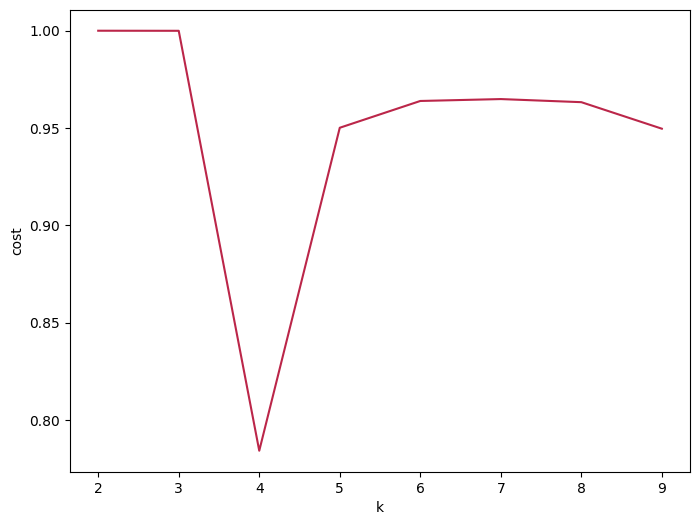

In [13]:
#Visualizing the silhouette scores in a plot
import matplotlib.pyplot as plt
fig, ax = plt.subplots(1,1, figsize =(8,6))
ax.plot(range(2,10),silhouette_score, color = '#BB2649')
ax.set_xlabel("k")
ax.set_ylabel("cost")

Text(0.5, 1.0, 'Elbow Curve')

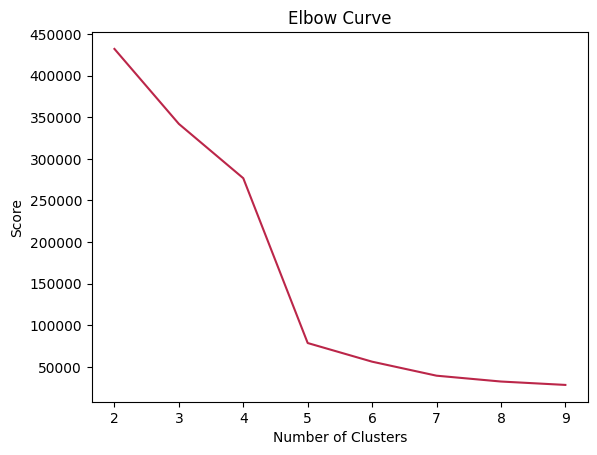

In [14]:
# Plot the cost
df_cost = pd.DataFrame(cost[2:])
df_cost.columns = ["cost"]
new_col = [2,3,4,5,6,7,8, 9]
df_cost.insert(0, 'cluster', new_col)

import pylab as pl
pl.plot(df_cost.cluster, df_cost.cost, color='#BB2649')
pl.xlabel('Number of Clusters')
pl.ylabel('Score')
pl.title('Elbow Curve')